In [ ]:
!wget "http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz" -O lingspam_public.tar.gz

In [ ]:
!tar -xvzf "lingspam_public.tar.gz"

In [3]:
def make_Dictionary(train_dir):
  '''
    Constructs a dataframe having 2 columns: Email and IsSpam from the text data?
  '''
  emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)]
  df = pd.DataFrame(columns =['message'])
  target_var = []
  for mail in emails:
    with open(mail) as m:
      data = m.read()
      if os.path.basename(m.name).find('spmsg'):
          target_var.append("spam")
      else:
          target_var.append("ham")
      df = df.append({'message':data}, ignore_index = True)
  df['class_label'] = pd.Series(target_var)
  return df

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

In [5]:
import os
import string
import numpy as np
from collections import Counter
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import confusion_matrix
import ntpath
import pandas as pd

df = make_Dictionary('lingspam_public/lemm_stop/part1')

train_dir = 'lingspam_public/lemm_stop/part'

# Combining all the 9 training sets
for i in range(2, 10):
  str1 = train_dir + str(i)
  new_df = make_Dictionary(str1)
  df = df.append(new_df)

In [6]:
df

,message,class_label
0,Subject: re : bengalus software\n\nsource beng...,spam
1,Subject: closing academic dept layoff san dieg...,spam
2,Subject: russian lecturer position cornell\n\n...,spam
3,Subject: re : 5 . 1254 typological classificat...,spam
4,Subject: merry month\n\nthank rick wojcik reme...,spam
...,...,...
284,Subject: symposium literacy write system asium...,spam
285,Subject: grammar school\n\n'd second herb stah...,spam
286,Subject: book - theorizing language\n\ntheoriz...,spam
287,Subject: book : cognitive linguistic\n\nangeli...,spam


In [7]:
df_spam = df[df.class_label=='spam']
df_ham = df[df.class_label=='ham']

In [8]:
# Import nltk packages and Punkt Tokenizer Models
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
ham_words = ''
spam_words = ''
# Creating a corpus of spam messages
for val in df_spam['message']:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
# Creating a corpus of ham messages
for val in df_ham['message']:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

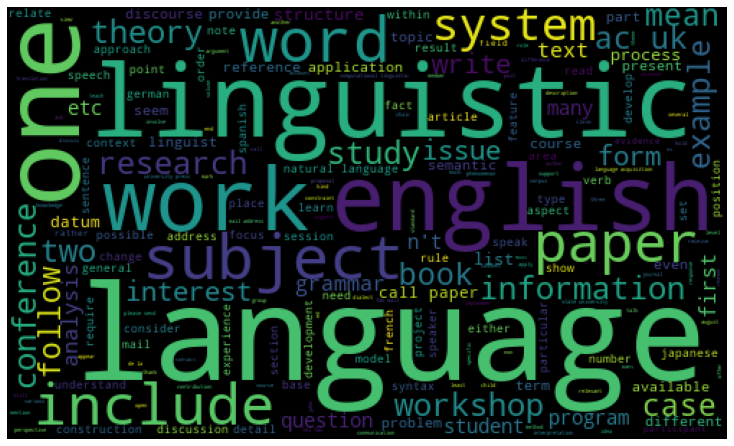

In [10]:
from wordcloud import WordCloud
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

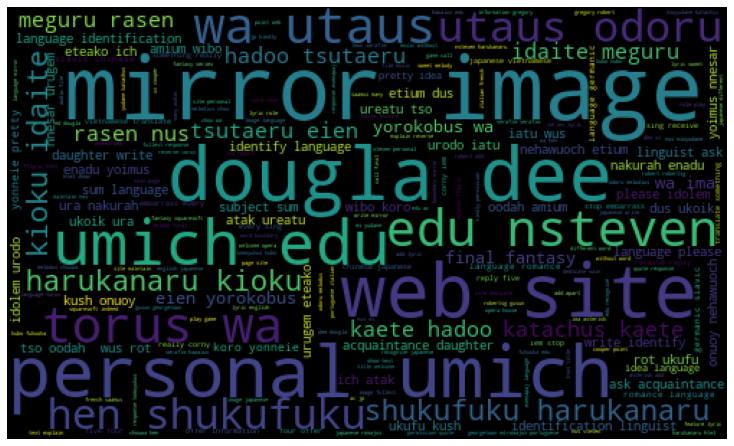

In [11]:
#Ham Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [12]:
df = df.replace(['ham','spam'],[0, 1])
df.head(10)
data = df

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import string
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [15]:
data['message'] = data['message'].apply(text_process)
data.head()

,message,class_label
0,Subject bengalus software source bengalus soft...,1
1,Subject closing academic dept layoff san diego...,1
2,Subject russian lecturer position cornell russ...,1
3,Subject 5 1254 typological classification wort...,1
4,Subject merry month thank rick wojcik remember...,1


In [16]:
text = pd.DataFrame(data['message'])
label = pd.DataFrame(data['class_label'])

In [17]:
## Counting how many times a word appears in the dataset
from collections import Counter
total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1
print("Total words in data set: ", len(total_counts))

Total words in data set:  55067


In [18]:
# Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['language', 'university', '0', 'email', 'linguistic', '1', 'de', 'address', 'one', 'information', 'Subject', '2', '20', 'e', 'send', 'conference', 'order', 'english', 'work', '3', 'please', 'include', 'mail', 'program', 'paper', 'name', '30', 'http', '5', 'list', 'edu', 'workshop', '10', '1998', 'word', 'fax', 'report', 'follow', 'research', '4', 'call', 'papers', 'system', 'abstract', 'nt', 'www', 'us', 'interest', 'receive', 'form', 'theory', 'study', 'first', 'book', 'number', 'linguistics', 'uk', 'c', 'submission', 'two']


In [19]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [20]:
# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [21]:
# Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])
word_vectors.shape

(2602, 55067)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()
tf_vectors = tf.fit_transform(data['message'])
tf_vectors.shape

(2602, 55038)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_vectors = cv.fit_transform(data['message'])
cv_vectors.shape

(2602, 55038)

In [23]:
features = tf_vectors
X_train, X_test, y_train, y_test = train_test_split(features, data['class_label'], test_size=0.15, random_state=111)

In [37]:
features_cv = cv_vectors
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(features_cv, data['class_label'], test_size=0.15, random_state=111)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [25]:
#initialize multiple classification models 
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [26]:
#create a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [27]:
#fit the data onto the models
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [28]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

In [29]:
pred_scores_word_vectors

[('SVC', [0.9923273657289002]),
 ('KN', [0.9872122762148338]),
 ('NB', [0.9872122762148338]),
 ('DT', [0.9616368286445013]),
 ('LR', [0.9667519181585678]),
 ('RF', [0.979539641943734])]

In [38]:
pred_scores_word_vectors_cv = []
for k,v in clfs.items():
    train(v, X_train_cv, y_train_cv)
    pred_cv = predict(v, X_test_cv)
    pred_scores_word_vectors_cv.append((k, [accuracy_score(y_test_cv , pred_cv)]))

In [39]:
pred_scores_word_vectors_cv

[('SVC', [0.7953964194373402]),
 ('KN', [0.887468030690537]),
 ('NB', [0.9974424552429667]),
 ('DT', [0.969309462915601]),
 ('LR', [0.989769820971867]),
 ('RF', [0.979539641943734])]

In [30]:
#write functions to detect if the message is spam or not
def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [31]:
newtext = ["Free entry"]
integers = tf.transform(newtext)

In [32]:
x = mnb.predict(integers)
find(x)

Message is SPAM


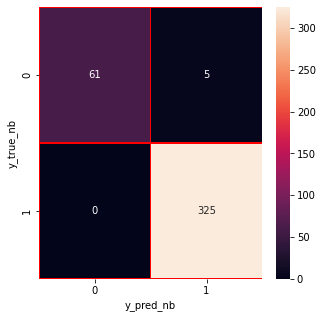

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Naive Bayes
y_pred_nb = mnb.predict(X_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_nb")
plt.ylabel("y_true_nb")
plt.show()